In [14]:
# Enze Xu
# Github: https://github.com/EnzeXu/PINN
# git clone https://github.com/EnzeXu/PINN.git

import torch
import time
import random
import argparse
import math
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
from torch import nn, optim
from tqdm import tqdm
from collections import OrderedDict
from torchsummary import summary
from torch.backends import cudnn

from google.colab import drive
drive.mount("/content/drive")

main_path = '/content/drive/My Drive/Workspace/PINN/' # ENZE marked: you need to change your main_path if it's not here
sys.path.append(main_path)

from cyclic_lr_scheduler import CyclicLR

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:

class ConfigSIRAges:
    T = 100.0
    T_unit = 0.01
    N = int(T / T_unit)
    S_start = 50.0  # 99.0
    I_start = 49.0 # 1.0
    R_start = 1.0 # 0.0
    NN = S_start + I_start + R_start
    beta = 0.4  # 0.01
    gamma = 0.04 # 0.05
    ub = T
    lb = 0.0
    mu = 0.03
    lam = mu * NN

    M = np.asarray([
      [19.200, 4.800, 5.050, 3.400, 1.700],
      [4.800, 42.400, 5.900, 6.250, 1.733],
      [5.050, 5.900, 14.000, 7.575, 1.700],
      [3.400, 6.250, 7.575, 9.575, 1.544],
      [1.700, 1.733, 1.700, 1.544, 5.456],
    ])
    n = len(M)

class SimpleNetworkSIRAges(nn.Module):
    def __init__(self, config):
        super(SimpleNetworkSIRAges, self).__init__()
        self.setup_seed(0)
        self.config = config
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.x, self.y0, self.t0 = None, None, None
        self.generate_x()
        # self.optimizer = optim.LBFGS(self.parameters(), lr=0.001, max_iter=5000, max_eval=None, tolerance_grad=1e-05, tolerance_change=1e-09, history_size=100, line_search_fn=None)
        self.initial_start()
        self.model_name = "SimpleNetworkSIRAges"
        self.sig = nn.Tanh()
        self.network_unit = 20
        # Design A
        # id = 1
        self.fc_x1_id1 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, self.network_unit),
            'sig1': self.sig,
            'lin2': nn.Linear(self.network_unit, self.network_unit),
            'sig2': self.sig,
            'lin3': nn.Linear(self.network_unit, self.network_unit),
            'sig3': self.sig,
            'lin4': nn.Linear(self.network_unit, 1),
            # 'sig4': nn.ReLU()
        }))

        self.fc_x2_id1 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, self.network_unit),
            'sig1': self.sig,
            'lin2': nn.Linear(self.network_unit, self.network_unit),
            'sig2': self.sig,
            'lin3': nn.Linear(self.network_unit, self.network_unit),
            'sig3': self.sig,
            'lin4': nn.Linear(self.network_unit, 1),
            # 'sig4': nn.ReLU()
        }))

        self.fc_x3_id1 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, self.network_unit),
            'sig1': self.sig,
            'lin2': nn.Linear(self.network_unit, self.network_unit),
            'sig2': self.sig,
            'lin3': nn.Linear(self.network_unit, self.network_unit),
            'sig3': self.sig,
            'lin4': nn.Linear(self.network_unit, 1),
            # 'sig4': nn.ReLU()
        }))

        # id = 2
        self.fc_x1_id2 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, self.network_unit),
            'sig1': self.sig,
            'lin2': nn.Linear(self.network_unit, self.network_unit),
            'sig2': self.sig,
            'lin3': nn.Linear(self.network_unit, self.network_unit),
            'sig3': self.sig,
            'lin4': nn.Linear(self.network_unit, 1),
            # 'sig4': nn.ReLU()
        }))

        self.fc_x2_id2 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, self.network_unit),
            'sig1': self.sig,
            'lin2': nn.Linear(self.network_unit, self.network_unit),
            'sig2': self.sig,
            'lin3': nn.Linear(self.network_unit, self.network_unit),
            'sig3': self.sig,
            'lin4': nn.Linear(self.network_unit, 1),
            # 'sig4': nn.ReLU()
        }))

        self.fc_x3_id2 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, self.network_unit),
            'sig1': self.sig,
            'lin2': nn.Linear(self.network_unit, self.network_unit),
            'sig2': self.sig,
            'lin3': nn.Linear(self.network_unit, self.network_unit),
            'sig3': self.sig,
            'lin4': nn.Linear(self.network_unit, 1),
            # 'sig4': nn.ReLU()
        }))

        # id = 3
        self.fc_x1_id3 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, self.network_unit),
            'sig1': self.sig,
            'lin2': nn.Linear(self.network_unit, self.network_unit),
            'sig2': self.sig,
            'lin3': nn.Linear(self.network_unit, self.network_unit),
            'sig3': self.sig,
            'lin4': nn.Linear(self.network_unit, 1),
            # 'sig4': nn.ReLU()
        }))

        self.fc_x2_id3 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, self.network_unit),
            'sig1': self.sig,
            'lin2': nn.Linear(self.network_unit, self.network_unit),
            'sig2': self.sig,
            'lin3': nn.Linear(self.network_unit, self.network_unit),
            'sig3': self.sig,
            'lin4': nn.Linear(self.network_unit, 1),
            # 'sig4': nn.ReLU()
        }))

        self.fc_x3_id3 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, self.network_unit),
            'sig1': self.sig,
            'lin2': nn.Linear(self.network_unit, self.network_unit),
            'sig2': self.sig,
            'lin3': nn.Linear(self.network_unit, self.network_unit),
            'sig3': self.sig,
            'lin4': nn.Linear(self.network_unit, 1),
            # 'sig4': nn.ReLU()
        }))

        # id = 4
        self.fc_x1_id4 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, self.network_unit),
            'sig1': self.sig,
            'lin2': nn.Linear(self.network_unit, self.network_unit),
            'sig2': self.sig,
            'lin3': nn.Linear(self.network_unit, self.network_unit),
            'sig3': self.sig,
            'lin4': nn.Linear(self.network_unit, 1),
            # 'sig4': nn.ReLU()
        }))

        self.fc_x2_id4 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, self.network_unit),
            'sig1': self.sig,
            'lin2': nn.Linear(self.network_unit, self.network_unit),
            'sig2': self.sig,
            'lin3': nn.Linear(self.network_unit, self.network_unit),
            'sig3': self.sig,
            'lin4': nn.Linear(self.network_unit, 1),
            # 'sig4': nn.ReLU()
        }))

        self.fc_x3_id4 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, self.network_unit),
            'sig1': self.sig,
            'lin2': nn.Linear(self.network_unit, self.network_unit),
            'sig2': self.sig,
            'lin3': nn.Linear(self.network_unit, self.network_unit),
            'sig3': self.sig,
            'lin4': nn.Linear(self.network_unit, 1),
            # 'sig4': nn.ReLU()
        }))

        # id = 5
        self.fc_x1_id5 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, self.network_unit),
            'sig1': self.sig,
            'lin2': nn.Linear(self.network_unit, self.network_unit),
            'sig2': self.sig,
            'lin3': nn.Linear(self.network_unit, self.network_unit),
            'sig3': self.sig,
            'lin4': nn.Linear(self.network_unit, 1),
            # 'sig4': nn.ReLU()
        }))

        self.fc_x2_id5 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, self.network_unit),
            'sig1': self.sig,
            'lin2': nn.Linear(self.network_unit, self.network_unit),
            'sig2': self.sig,
            'lin3': nn.Linear(self.network_unit, self.network_unit),
            'sig3': self.sig,
            'lin4': nn.Linear(self.network_unit, 1),
            # 'sig4': nn.ReLU()
        }))

        self.fc_x3_id5 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, self.network_unit),
            'sig1': self.sig,
            'lin2': nn.Linear(self.network_unit, self.network_unit),
            'sig2': self.sig,
            'lin3': nn.Linear(self.network_unit, self.network_unit),
            'sig3': self.sig,
            'lin4': nn.Linear(self.network_unit, 1),
            # 'sig4': nn.ReLU()
        }))

        # # Design D
        # # id = 1
        # self.fc_x1_0_1_id1 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x2_0_1_id1 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x3_0_1_id1 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x1_1_2_id1 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear((self.config.n + 1) * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x2_1_2_id1 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear((self.config.n + 1) * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x3_1_2_id1 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1 * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x1_2_3_id1 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear((self.config.n + 1) * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x2_2_3_id1 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear((self.config.n + 1) * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x3_2_3_id1 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1 * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x1_3_4_id1 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(self.network_unit, 1),
        # }))

        # self.fc_x2_3_4_id1 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(self.network_unit, 1),
        # }))

        # self.fc_x3_3_4_id1 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(self.network_unit, 1),
        # }))

        # # id = 2
        # self.fc_x1_0_1_id2 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x2_0_1_id2 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x3_0_1_id2 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x1_1_2_id2 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear((self.config.n + 1) * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x2_1_2_id2 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear((self.config.n + 1) * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x3_1_2_id2 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1 * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x1_2_3_id2 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear((self.config.n + 1) * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x2_2_3_id2 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear((self.config.n + 1) * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x3_2_3_id2 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1 * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x1_3_4_id2 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(self.network_unit, 1),
        # }))

        # self.fc_x2_3_4_id2 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(self.network_unit, 1),
        # }))

        # self.fc_x3_3_4_id2 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(self.network_unit, 1),
        # }))

        # # id = 3
        # self.fc_x1_0_1_id3 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x2_0_1_id3 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x3_0_1_id3 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x1_1_2_id3 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear((self.config.n + 1) * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x2_1_2_id3 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear((self.config.n + 1) * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x3_1_2_id3 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1 * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x1_2_3_id3 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear((self.config.n + 1) * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x2_2_3_id3 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear((self.config.n + 1) * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x3_2_3_id3 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1 * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x1_3_4_id3 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(self.network_unit, 1),
        # }))

        # self.fc_x2_3_4_id3 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(self.network_unit, 1),
        # }))

        # self.fc_x3_3_4_id3 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(self.network_unit, 1),
        # }))

        # # id = 4
        # self.fc_x1_0_1_id4 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x2_0_1_id4 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x3_0_1_id4 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x1_1_2_id4 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear((self.config.n + 1) * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x2_1_2_id4 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear((self.config.n + 1) * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x3_1_2_id4 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1 * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x1_2_3_id4 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear((self.config.n + 1) * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x2_2_3_id4 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear((self.config.n + 1) * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x3_2_3_id4 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1 * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x1_3_4_id4 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(self.network_unit, 1),
        # }))

        # self.fc_x2_3_4_id4 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(self.network_unit, 1),
        # }))

        # self.fc_x3_3_4_id4 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(self.network_unit, 1),
        # }))

        # # id = 5
        # self.fc_x1_0_1_id5 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x2_0_1_id5 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x3_0_1_id5 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x1_1_2_id5 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear((self.config.n + 1) * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x2_1_2_id5 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear((self.config.n + 1) * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x3_1_2_id5 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1 * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x1_2_3_id5 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear((self.config.n + 1) * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x2_2_3_id5 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear((self.config.n + 1) * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x3_2_3_id5 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1 * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x1_3_4_id5 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(self.network_unit, 1),
        # }))

        # self.fc_x2_3_4_id5 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(self.network_unit, 1),
        # }))

        # self.fc_x3_3_4_id5 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(self.network_unit, 1),
        # }))

    def forward(self, inputs):
        # print(inputs.shape)
        # print("inputs=", inputs)
        x1_id1, x1_id2, x1_id3, x1_id4, x1_id5, x2_id1, x2_id2, x2_id3, x2_id4, x2_id5, x3_id1, x3_id2, x3_id3, x3_id4, x3_id5 = torch.chunk(inputs, 15, 1)
        
        # Design A
        x1_new_id1 = self.fc_x1_id1(x1_id1)
        x2_new_id1 = self.fc_x2_id1(x2_id1)
        x3_new_id1 = self.fc_x3_id1(x3_id1)

        x1_new_id2 = self.fc_x1_id2(x1_id2)
        x2_new_id2 = self.fc_x2_id2(x2_id2)
        x3_new_id2 = self.fc_x3_id2(x3_id2)

        x1_new_id3 = self.fc_x1_id3(x1_id3)
        x2_new_id3 = self.fc_x2_id3(x2_id3)
        x3_new_id3 = self.fc_x3_id3(x3_id3)

        x1_new_id4 = self.fc_x1_id4(x1_id4)
        x2_new_id4 = self.fc_x2_id4(x2_id4)
        x3_new_id4 = self.fc_x3_id4(x3_id4)

        x1_new_id5 = self.fc_x1_id5(x1_id5)
        x2_new_id5 = self.fc_x2_id5(x2_id5)
        x3_new_id5 = self.fc_x3_id5(x3_id5)


        # # Design D
        # # 1 output train
        # x1_1_output_id1 = self.fc_x1_0_1_id1(x1_id1)
        # x2_1_output_id1 = self.fc_x2_0_1_id1(x2_id1)
        # x3_1_output_id1 = self.fc_x3_0_1_id1(x3_id1)

        # x1_1_output_id2 = self.fc_x1_0_1_id2(x1_id2)
        # x2_1_output_id2 = self.fc_x2_0_1_id2(x2_id2)
        # x3_1_output_id2 = self.fc_x3_0_1_id2(x3_id2)

        # x1_1_output_id3 = self.fc_x1_0_1_id3(x1_id3)
        # x2_1_output_id3 = self.fc_x2_0_1_id3(x2_id3)
        # x3_1_output_id3 = self.fc_x3_0_1_id3(x3_id3)

        # x1_1_output_id4 = self.fc_x1_0_1_id4(x1_id4)
        # x2_1_output_id4 = self.fc_x2_0_1_id4(x2_id4)
        # x3_1_output_id4 = self.fc_x3_0_1_id4(x3_id4)

        # x1_1_output_id5 = self.fc_x1_0_1_id5(x1_id5)
        # x2_1_output_id5 = self.fc_x2_0_1_id5(x2_id5)
        # x3_1_output_id5 = self.fc_x3_0_1_id5(x3_id5)

        # # 2 input cat
        # x1_2_input_id1 = torch.cat((x1_1_output_id1, x2_1_output_id1, x2_1_output_id2, x2_1_output_id3, x2_1_output_id4, x2_1_output_id5), 1)
        # x2_2_input_id1 = torch.cat((x1_1_output_id1, x2_1_output_id1, x2_1_output_id2, x2_1_output_id3, x2_1_output_id4, x2_1_output_id5), 1)
        # x3_2_input_id1 = x2_1_output_id1

        # x1_2_input_id2 = torch.cat((x1_1_output_id2, x2_1_output_id1, x2_1_output_id2, x2_1_output_id3, x2_1_output_id4, x2_1_output_id5), 1)
        # x2_2_input_id2 = torch.cat((x1_1_output_id2, x2_1_output_id1, x2_1_output_id2, x2_1_output_id3, x2_1_output_id4, x2_1_output_id5), 1)
        # x3_2_input_id2 = x2_1_output_id2

        # x1_2_input_id3 = torch.cat((x1_1_output_id3, x2_1_output_id1, x2_1_output_id2, x2_1_output_id3, x2_1_output_id4, x2_1_output_id5), 1)
        # x2_2_input_id3 = torch.cat((x1_1_output_id3, x2_1_output_id1, x2_1_output_id2, x2_1_output_id3, x2_1_output_id4, x2_1_output_id5), 1)
        # x3_2_input_id3 = x2_1_output_id3

        # x1_2_input_id4 = torch.cat((x1_1_output_id4, x2_1_output_id1, x2_1_output_id2, x2_1_output_id3, x2_1_output_id4, x2_1_output_id5), 1)
        # x2_2_input_id4 = torch.cat((x1_1_output_id4, x2_1_output_id1, x2_1_output_id2, x2_1_output_id3, x2_1_output_id4, x2_1_output_id5), 1)
        # x3_2_input_id4 = x2_1_output_id4

        # x1_2_input_id5 = torch.cat((x1_1_output_id5, x2_1_output_id1, x2_1_output_id2, x2_1_output_id3, x2_1_output_id4, x2_1_output_id5), 1)
        # x2_2_input_id5 = torch.cat((x1_1_output_id5, x2_1_output_id1, x2_1_output_id2, x2_1_output_id3, x2_1_output_id4, x2_1_output_id5), 1)
        # x3_2_input_id5 = x2_1_output_id5

        # # 2 output train
        # x1_2_output_id1 = self.fc_x1_1_2_id1(x1_2_input_id1)
        # x2_2_output_id1 = self.fc_x2_1_2_id1(x2_2_input_id1)
        # x3_2_output_id1 = self.fc_x3_1_2_id1(x3_2_input_id1)

        # x1_2_output_id2 = self.fc_x1_1_2_id2(x1_2_input_id2)
        # x2_2_output_id2 = self.fc_x2_1_2_id2(x2_2_input_id2)
        # x3_2_output_id2 = self.fc_x3_1_2_id2(x3_2_input_id2)

        # x1_2_output_id3 = self.fc_x1_1_2_id3(x1_2_input_id3)
        # x2_2_output_id3 = self.fc_x2_1_2_id3(x2_2_input_id3)
        # x3_2_output_id3 = self.fc_x3_1_2_id3(x3_2_input_id3)

        # x1_2_output_id4 = self.fc_x1_1_2_id4(x1_2_input_id4)
        # x2_2_output_id4 = self.fc_x2_1_2_id4(x2_2_input_id4)
        # x3_2_output_id4 = self.fc_x3_1_2_id4(x3_2_input_id4)

        # x1_2_output_id5 = self.fc_x1_1_2_id5(x1_2_input_id5)
        # x2_2_output_id5 = self.fc_x2_1_2_id5(x2_2_input_id5)
        # x3_2_output_id5 = self.fc_x3_1_2_id5(x3_2_input_id5)

        # # 3 input cat
        # x1_3_input_id1 = torch.cat((x1_2_output_id1, x2_2_output_id1, x2_2_output_id2, x2_2_output_id3, x2_2_output_id4, x2_2_output_id5), 1)
        # x2_3_input_id1 = torch.cat((x1_2_output_id1, x2_2_output_id1, x2_2_output_id2, x2_2_output_id3, x2_2_output_id4, x2_2_output_id5), 1)
        # x3_3_input_id1 = x2_2_output_id1

        # x1_3_input_id2 = torch.cat((x1_2_output_id2, x2_2_output_id1, x2_2_output_id2, x2_2_output_id3, x2_2_output_id4, x2_2_output_id5), 1)
        # x2_3_input_id2 = torch.cat((x1_2_output_id2, x2_2_output_id1, x2_2_output_id2, x2_2_output_id3, x2_2_output_id4, x2_2_output_id5), 1)
        # x3_3_input_id2 = x2_2_output_id2

        # x1_3_input_id3 = torch.cat((x1_2_output_id3, x2_2_output_id1, x2_2_output_id2, x2_2_output_id3, x2_2_output_id4, x2_2_output_id5), 1)
        # x2_3_input_id3 = torch.cat((x1_2_output_id3, x2_2_output_id1, x2_2_output_id2, x2_2_output_id3, x2_2_output_id4, x2_2_output_id5), 1)
        # x3_3_input_id3 = x2_2_output_id3

        # x1_3_input_id4 = torch.cat((x1_2_output_id4, x2_2_output_id1, x2_2_output_id2, x2_2_output_id3, x2_2_output_id4, x2_2_output_id5), 1)
        # x2_3_input_id4 = torch.cat((x1_2_output_id4, x2_2_output_id1, x2_2_output_id2, x2_2_output_id3, x2_2_output_id4, x2_2_output_id5), 1)
        # x3_3_input_id4 = x2_2_output_id4

        # x1_3_input_id5 = torch.cat((x1_2_output_id5, x2_2_output_id1, x2_2_output_id2, x2_2_output_id3, x2_2_output_id4, x2_2_output_id5), 1)
        # x2_3_input_id5 = torch.cat((x1_2_output_id5, x2_2_output_id1, x2_2_output_id2, x2_2_output_id3, x2_2_output_id4, x2_2_output_id5), 1)
        # x3_3_input_id5 = x2_2_output_id5

        # # 3 output train
        # x1_3_output_id1 = self.fc_x1_2_3_id1(x1_3_input_id1)
        # x2_3_output_id1 = self.fc_x2_2_3_id1(x2_3_input_id1)
        # x3_3_output_id1 = self.fc_x3_2_3_id1(x3_3_input_id1)

        # x1_3_output_id2 = self.fc_x1_2_3_id2(x1_3_input_id2)
        # x2_3_output_id2 = self.fc_x2_2_3_id2(x2_3_input_id2)
        # x3_3_output_id2 = self.fc_x3_2_3_id2(x3_3_input_id2)

        # x1_3_output_id3 = self.fc_x1_2_3_id3(x1_3_input_id3)
        # x2_3_output_id3 = self.fc_x2_2_3_id3(x2_3_input_id3)
        # x3_3_output_id3 = self.fc_x3_2_3_id3(x3_3_input_id3)

        # x1_3_output_id4 = self.fc_x1_2_3_id4(x1_3_input_id4)
        # x2_3_output_id4 = self.fc_x2_2_3_id4(x2_3_input_id4)
        # x3_3_output_id4 = self.fc_x3_2_3_id4(x3_3_input_id4)

        # x1_3_output_id5 = self.fc_x1_2_3_id5(x1_3_input_id5)
        # x2_3_output_id5 = self.fc_x2_2_3_id5(x2_3_input_id5)
        # x3_3_output_id5 = self.fc_x3_2_3_id5(x3_3_input_id5)

        # # final output
        # x1_new_id1 = self.fc_x1_3_4_id1(x1_3_output_id1)
        # x2_new_id1 = self.fc_x2_3_4_id1(x2_3_output_id1)
        # x3_new_id1 = self.fc_x3_3_4_id1(x3_3_output_id1)

        # x1_new_id2 = self.fc_x1_3_4_id2(x1_3_output_id2)
        # x2_new_id2 = self.fc_x2_3_4_id2(x2_3_output_id2)
        # x3_new_id2 = self.fc_x3_3_4_id2(x3_3_output_id2)

        # x1_new_id3 = self.fc_x1_3_4_id3(x1_3_output_id3)
        # x2_new_id3 = self.fc_x2_3_4_id3(x2_3_output_id3)
        # x3_new_id3 = self.fc_x3_3_4_id3(x3_3_output_id3)

        # x1_new_id4 = self.fc_x1_3_4_id4(x1_3_output_id4)
        # x2_new_id4 = self.fc_x2_3_4_id4(x2_3_output_id4)
        # x3_new_id4 = self.fc_x3_3_4_id4(x3_3_output_id4)

        # x1_new_id5 = self.fc_x1_3_4_id5(x1_3_output_id5)
        # x2_new_id5 = self.fc_x2_3_4_id5(x2_3_output_id5)
        # x3_new_id5 = self.fc_x3_3_4_id5(x3_3_output_id5)

        outputs = torch.cat((x1_new_id1, x1_new_id2, x1_new_id3, x1_new_id4, x1_new_id5, x2_new_id1, x2_new_id2, x2_new_id3, x2_new_id4, x2_new_id5, x3_new_id1, x3_new_id2, x3_new_id3, x3_new_id4, x3_new_id5), 1)
        return outputs

    def generate_x(self):
        x = [[i*self.config.T_unit] * (self.config.n * 3) for i in range(self.config.N)]  # toy
        x = np.asarray(x)
        x = self.encode_t(x)
        self.x = torch.Tensor(x).float().to(self.device)
        # print("self.x=", x)

    def initial_start(self):
        self.t0 = torch.Tensor(np.asarray([-1.0, -1.0, -1.0] * self.config.n).reshape([1, -1])).float().to(self.device)
        self.y0 = torch.Tensor(np.asarray(
            [self.config.S_start] * self.config.n + [self.config.I_start] * self.config.n + [self.config.R_start] * self.config.n
            ).reshape([1, -1])).float().to(self.device)
        # self.yend = torch.Tensor(np.asarray([0, 0, 100]).reshape([1, -1])).float().to(self.device)
        # self.tend = torch.Tensor(np.asarray([1.0, 1.0, 1.0]).reshape([1, -1])).float().to(self.device)

    def loss(self):
        self.eval()
        y = self.forward(self.x)
        # s = y[:, 0:1]
        # i = y[:, 1:2]
        # r = y[:, 2:3]
        s = y[:, 0: self.config.n]
        i = y[:, self.config.n: self.config.n * 2]
        r = y[:, self.config.n * 2: self.config.n * 3]

        s_t_collection, i_t_collection, r_t_collection = [], [], []
        for ii in range(self.config.n):
          s_t_collection.append(torch.gradient(s[:,ii:ii+1].reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0].reshape([self.config.N,1]))
          i_t_collection.append(torch.gradient(i[:,ii:ii+1].reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0].reshape([self.config.N,1]))
          r_t_collection.append(torch.gradient(r[:,ii:ii+1].reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0].reshape([self.config.N,1]))
        s_t = torch.cat(s_t_collection, 1)
        i_t = torch.cat(i_t_collection, 1)
        r_t = torch.cat(r_t_collection, 1)


        # s_ids, i_ids, r_ids = [], [], []
        # for i in range(self.config.n):
        #   s_ids.append(y[:, i:i+1])
        #   i_ids.append(y[:, self.config.n+i: self.config.n+i+1])
        #   r_ids.append(y[:, 2*self.config.n+i: 2*self.config.n+i+1])
        
        # s_t = torch.gradient(y[:, 0:1].reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0]
        # i_t = torch.gradient(y[:, 1:2].reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 1:2].reshape([self.config.N]),))[0]
        # r_t = torch.gradient(y[:, 2:3].reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 2:3].reshape([self.config.N]),))[0]
        # s_t_ids, i_t_ids, r_t_ids = [], [], []
        # for i in range(self.config.n):
        #   s_t_ids.append(torch.gradient(s_ids[i].reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0].reshape([self.config.N, 1]))
        #   i_t_ids.append(torch.gradient(i_ids[i].reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0].reshape([self.config.N, 1]))
        #   r_t_ids.append(torch.gradient(r_ids[i].reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0].reshape([self.config.N, 1]))
        
        # s_t = s_t.reshape([self.config.N, 1])
        # i_t = i_t.reshape([self.config.N, 1])
        # r_t = r_t.reshape([self.config.N, 1])
        
        # f_s = s_t - (- self.config.beta * s * i / self.config.NN + self.config.lam - self.config.mu * s)
        # f_i = i_t - (self.config.beta * s * i / self.config.NN - self.config.gamma * i - self.config.mu * i)
        # f_r = r_t - (self.config.gamma * i - self.config.mu * r)

        tmp_s_t_target_collection, tmp_i_t_target_collection, tmp_r_t_target_collection = [], [], []
        for ii in range(self.config.n):
          tmp_s_t_target = torch.zeros([self.config.N, 1]).to(self.device)
          tmp_i_t_target = torch.zeros([self.config.N, 1]).to(self.device)
          tmp_r_t_target = torch.zeros([self.config.N, 1]).to(self.device)
          for jj in range(self.config.n):
            # print(s[:, ii:ii+1].shape)
            # print(self.config.M[i][jj])
            tmp_s_t_target += (-self.config.beta * s[:, ii:ii+1] * self.config.M[ii][jj] * i[:, jj:jj+1])
            tmp_i_t_target += (self.config.beta * s[:, ii:ii+1] * self.config.M[ii][jj] * i[:, jj:jj+1])
          tmp_i_t_target -= self.config.gamma * i[:, ii:ii+1]
          tmp_r_t_target += self.config.gamma * i[:, ii:ii+1]
          tmp_s_t_target += (- self.config.mu * s[:, ii:ii+1] + self.config.lam)
          tmp_i_t_target += (- self.config.mu * i[:, ii:ii+1])
          tmp_r_t_target += (- self.config.mu * r[:, ii:ii+1])
          tmp_s_t_target_collection.append(tmp_s_t_target)
          tmp_i_t_target_collection.append(tmp_i_t_target)
          tmp_r_t_target_collection.append(tmp_r_t_target)
        s_t_target = torch.cat(tmp_s_t_target_collection, 1)
        i_t_target = torch.cat(tmp_i_t_target_collection, 1)
        r_t_target = torch.cat(tmp_r_t_target_collection, 1)

        f_s = s_t - s_t_target
        f_i = i_t - i_t_target
        f_r = r_t - r_t_target

        
        f_y = torch.cat((f_s, f_i, f_r), 1)
        y0_pred = self.forward(self.t0)
        
        # i_1 = i[:, 0:1]
        # i_2 = i[:, 1:2]
        # i_3 = i[:, 2:3]
        # i_4 = i[:, 3:4]
        # i_5 = i[:, 4:5]

        # r_1 = r[:, 0:1]
        # r_2 = r[:, 1:2]
        # r_3 = r[:, 2:3]
        # r_4 = r[:, 3:4]
        # r_5 = r[:, 4:5]

        loss_1 = torch.mean(torch.square(self.y0 - y0_pred))
        loss_2 = torch.mean(torch.square(f_y))  # + torch.var(torch.square(f_y))
        # loss_3 = torch.mean(torch.square((torch.abs(s) - s))) + torch.mean(torch.square((torch.abs(i) - i))) + torch.mean(torch.square((torch.abs(r) - r))) #+ torch.mean(torch.square((0.1/(s * s)))) + torch.mean(torch.square((0.1/(i * i)))) + torch.mean(torch.square((0.1/(r * r))))
        # loss_4 = torch.mean(torch.square(0.00001 / ((s * s + i * i) * (i * i + r * r) * (s * s + r * r) + 1e-8)))

        # 04/27 TODO: re-design the loss functions. I want to do it but Chen asked me to implement new models. Now it's your turn.

        loss = loss_1 + loss_2 # + loss_3 + loss_4
        # if loss < 2.0:
        #     f_y_square_pure = torch.square(f_y).cpu().detach().numpy()
        #     for i in range(20000):
        #         print(i, f_y_square_pure[i])
        self.train()
        return loss, [loss_1, loss_2, loss_3]
        # return torch.mean(torch.square(y_hat - y))
        # return F.mse_loss(torch.cat((u_hat, v_hat), 1), torch.cat((u, v), 1))
        # return torch.abs(u_hat - u) + torch.abs(v_hat - v)  # F.mse_loss(x_hat, x) + beta * self.kl_div(rho)


    def encode_t(self, num):
        return (num - self.config.lb) / (self.config.ub - self.config.lb) * 2.0 - 1.0

    def decode_t(self, num):
        return self.config.lb + (num + 1.0) / 2.0 * (self.config.ub - self.config.lb)

    @staticmethod
    def setup_seed(seed):
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        random.seed(seed)
        cudnn.deterministic = True

In [21]:
def get_now_string():
    return time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime(time.time()))
  

def draw_two_dimension(
        y_lists,
        x_list,
        color_list,
        line_style_list,
        legend_list=None,
        legend_fontsize=15,
        fig_title=None,
        fig_x_label="time",
        fig_y_label="val",
        show_flag=True,
        save_flag=False,
        save_path=None,
        save_dpi=300,
        fig_title_size=20,
        fig_grid=False,
        marker_size=0,
        line_width=2,
        x_label_size=15,
        y_label_size=15,
        number_label_size=15,
        fig_size=(8, 6)
) -> None:
    """
    Draw a 2D plot of several lines
    :param y_lists: (list[list]) y value of lines, each list in which is one line. e.g., [[2,3,4,5], [2,1,0,-1], [1,4,9,16]]
    :param x_list: (list) x value shared by all lines. e.g., [1,2,3,4]
    :param color_list: (list) color of each line. e.g., ["red", "blue", "green"]
    :param line_style_list: (list) line style of each line. e.g., ["solid", "dotted", "dashed"]
    :param legend_list: (list) legend of each line, which CAN BE LESS THAN NUMBER of LINES. e.g., ["red line", "blue line", "green line"]
    :param legend_fontsize: (float) legend fontsize. e.g., 15
    :param fig_title: (string) title of the figure. e.g., "Anonymous"
    :param fig_x_label: (string) x label of the figure. e.g., "time"
    :param fig_y_label: (string) y label of the figure. e.g., "val"
    :param show_flag: (boolean) whether you want to show the figure. e.g., True
    :param save_flag: (boolean) whether you want to save the figure. e.g., False
    :param save_path: (string) If you want to save the figure, give the save path. e.g., "./test.png"
    :param save_dpi: (integer) If you want to save the figure, give the save dpi. e.g., 300
    :param fig_title_size: (float) figure title size. e.g., 20
    :param fig_grid: (boolean) whether you want to display the grid. e.g., True
    :param marker_size: (float) marker size. e.g., 0
    :param line_width: (float) line width. e.g., 1
    :param x_label_size: (float) x label size. e.g., 15
    :param y_label_size: (float) y label size. e.g., 15
    :param number_label_size: (float) number label size. e.g., 15
    :param fig_size: (tuple) figure size. e.g., (8, 6)
    :return:
    """
    assert len(y_lists[0]) == len(x_list), "Dimension of y should be same to that of x"
    assert len(y_lists) == len(line_style_list) == len(color_list), "number of lines should be fixed"
    y_count = len(y_lists)
    plt.figure(figsize=fig_size)
    for i in range(y_count):
        plt.plot(x_list, y_lists[i], markersize=marker_size, linewidth=line_width, c=color_list[i], linestyle=line_style_list[i])
    plt.xlabel(fig_x_label, fontsize=x_label_size)
    plt.ylabel(fig_y_label, fontsize=y_label_size)
    plt.tick_params(labelsize=number_label_size)
    if legend_list:
        plt.legend(legend_list, fontsize=legend_fontsize)
    if fig_title:
        plt.title(fig_title, fontsize=fig_title_size)
    if fig_grid:
        plt.grid(True)
    if save_flag:
        plt.savefig(save_path, dpi=save_dpi)
    if show_flag:
        plt.show()
    plt.clf()

def train_sir_ages(model, args, config, now_string):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model = model_framework(config).to(device)
    model.train()
    model_save_path_last = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.beta}_{config.gamma}_{now_string}_last.pt"
    model_save_path_best = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.beta}_{config.gamma}_{now_string}_best.pt"
    print("using " + str(device))
    print("epoch = {}".format(args.epoch))
    print("epoch_step = {}".format(args.epoch_step))
    print("model_name = {}".format(model.model_name))
    print("now_string = {}".format(now_string))
    print("model_save_path_last = {}".format(model_save_path_last))
    print("model_save_path_best = {}".format(model_save_path_best))
    # optimizer = optim.Adam(model.parameters(), lr=args.lr)
    initial_lr = args.lr
    optimizer = optim.Adam(model.parameters(), lr = initial_lr)
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1/(epoch/10000+1))
    # scheduler = CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, step_size=1000)
    # optimizer = optim.LBFGS(model.parameters(), lr=args.lr, max_iter=5000, max_eval=None, tolerance_grad=1e-05, tolerance_change=1e-09, history_size=100,
    #       line_search_fn=None)
    epoch_step = args.epoch_step
    start_time = time.time()
    start_time_0 = start_time
    for epoch in range(1, args.epoch + 1):
        optimizer.zero_grad()
        inputs = model.x
        outputs = model(inputs)
        # u_hat, v_hat = torch.chunk(outputs, 2, 1)
        loss, loss_list = model.loss()
        loss_1, loss_2, loss_3 = loss_list[0], loss_list[1], loss_list[2]
        loss.backward()
        optimizer.step()
        scheduler.step()
        best_loss = 999999
        if epoch % epoch_step == 0:
            now_time = time.time()
            print("Epoch [{0:05d}/{1:05d}] Loss:{2:.6f} Loss_1:{3:.6f} Loss_2:{4:.6f} Loss_3:{5:.6f} Lr:{6:.6f} Time:{7:.6f}s ({8:.2f}min in total)".format(epoch, args.epoch, loss.item(), loss_1.item(), loss_2.item(), loss_3.item(), optimizer.param_groups[0]["lr"], time.time() - start_time, (now_time - start_time_0) / 60.0))
            start_time = time.time()
            torch.save(
                {
                    'epoch': args.epoch,
                    'model_state_dict': model.state_dict(),
                    # 'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss.item()
                }, model_save_path_last)
            # print(inputs.shape)
            if loss.item() < best_loss:
                torch.save(
                    {
                        'epoch': args.epoch,
                        'model_state_dict': model.state_dict(),
                        # 'optimizer_state_dict': optimizer.state_dict(),
                        'loss': loss.item()
                    }, model_save_path_best)
        if epoch % args.save_step == 0:
            test_sir_ages(model, args, config, now_string, True)

def test_sir_ages(model, args, config, now_string, show_flag=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model = model_framework(config).to(device)
    model_save_path = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.beta}_{config.gamma}_{now_string}_last.pt"
    model.load_state_dict(torch.load(model_save_path, map_location=device)["model_state_dict"])
    model.eval()
    print("Testing & drawing...")
    t = model.x
    y = model(t)
    y0_pred = model(model.t0)
    s, i, r = y[:, 0:5], y[:, 5:10], y[:, 10:15]
    s = s.cpu().detach().numpy()
    i = i.cpu().detach().numpy()
    r = r.cpu().detach().numpy()
    x = model.decode_t(t).cpu().detach().numpy()
    s_pred = [s[:, id:id+1].reshape([model.config.N]) for id in range(model.config.n)]
    i_pred = [i[:, id:id+1].reshape([model.config.N]) for id in range(model.config.n)]
    r_pred = [r[:, id:id+1].reshape([model.config.N]) for id in range(model.config.n)]
    x = x[:, 0:1].reshape([model.config.N])
    for id in range(model.config.n):
      print(f"s{id+1}=", list(s_pred[id][:10]), "...", list(s_pred[id][-10:]))
    for id in range(model.config.n):
      print(f"i{id+1}=", list(i_pred[id][:10]), "...", list(i_pred[id][-10:]))
    for id in range(model.config.n):
      print(f"r{id+1}=", list(r_pred[id][:10]), "...", list(r_pred[id][-10:]))

    figure_save_path = f"{args.main_path}/figure/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.beta}_{config.gamma}_{now_string}_{int(time.time())}.png"
    labels = ["0-9", "10-19", "20-39", "40-59", "60+"]
    color_list = ["red"] * model.config.n + ["blue"] * model.config.n + ["green"] * model.config.n
    legend_list = ["S{}({})".format(i + 1, labels[i]) for i in range(model.config.n)] + ["I{}({})".format(i + 1, labels[i]) for i in range(model.config.n)] + ["R{}({})".format(i + 1, labels[i]) for i in range(model.config.n)]
    line_style_list = ["dashed", "dotted", "dashdot", (0, (3, 1, 1, 1, 1, 1)), (0, (3, 10, 1, 10))] * 3
    draw_two_dimension(
        y_lists=s_pred+i_pred+r_pred,
        x_list=x,
        color_list=color_list,
        legend_list=legend_list,
        line_style_list=line_style_list,
        fig_title="Predict: SIR - Ages",
        fig_size=(32, 18),
        show_flag=True,
        save_flag=True,
        save_path=figure_save_path
    )
    # pairs = [[ss, ii, rr, xx] for ss, ii, rr, xx in zip(s, i, r, x)]
    # pairs.sort(key=lambda xx: xx[-1])
    # s = [item[0] for item in pairs]
    # i = [item[1] for item in pairs]
    # r = [item[2] for item in pairs]
    # x = [item[3] for item in pairs]
    # print("s=", s[:10], "...", s[-10:])
    # print("i=", i[:10], "...", i[-10:])
    # print("r=", r[:10], "...", r[-10:])
    # print("x=", x[:10], "...", x[-10:])
    # plt.plot(x, s, marker='.', markersize=0.2, linewidth=0.1, c="b")
    # plt.plot(x, i, marker='.', markersize=0.2, linewidth=0.1, c="r")
    # plt.plot(x, r, marker='.', markersize=0.2, linewidth=0.1, c="g")
    # figure_save_path = f"{args.main_path}/figure/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.beta}_{config.gamma}_{now_string}_{int(time.time())}.png"
    # plt.savefig(figure_save_path, dpi=300)
    # if show_flag:
    #     plt.show()
    # plt.clf()
    # print("Saved as {}".format(figure_save_path))

class Args:
  epoch = 500
  epoch_step = 1
  lr = 0.001
  main_path = "."
  save_step = 20

def draw_loss(loss_list):
    map = np.asarray([[loss] for loss in loss_list])
    plt.plot(map)
    plt.show()
    plt.clf()

def run_sir_ages(main_path=None):
    # parser = argparse.ArgumentParser()
    # parser.add_argument("--epoch", type=int, default=1000, help="epoch")
    # parser.add_argument("--epoch_step", type=int, default=10, help="epoch_step")
    # parser.add_argument('--lr', type=float, default=0.01, help='learning rate, default=0.001')
    # parser.add_argument("--main_path", default=".", help="main_path")
    # parser.add_argument("--save_step", type=int, default=100, help="save_step")
    # args = parser.parse_args()
    args = Args
    if main_path:
        args.main_path = main_path
    if not os.path.exists("{}/train".format(args.main_path)):
        os.makedirs("{}/train".format(args.main_path))
    if not os.path.exists("{}/figure".format(args.main_path)):
        os.makedirs("{}/figure".format(args.main_path))
    now_string = get_now_string()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    config = ConfigSIRAges
    model = SimpleNetworkSIRAges(config).to(device)
    train_sir_ages(model, args, config, now_string)
    model = SimpleNetworkSIRAges(config).to(device)
    test_sir_ages(model, args, config, now_string)

In [ ]:
main_path = "/content/drive/My Drive/Workspace/PINN"  # you may need to alter the path if it's not here
run_sir_ages(main_path)

using cuda
epoch = 500
epoch_step = 1
model_name = SimpleNetworkSIRAges
now_string = 2022-04-27-14-59-08
model_save_path_last = /content/drive/My Drive/Workspace/PINN/train/SimpleNetworkSIRAges_500_1_0.001_0.4_0.04_2022-04-27-14-59-08_last.pt
model_save_path_best = /content/drive/My Drive/Workspace/PINN/train/SimpleNetworkSIRAges_500_1_0.001_0.4_0.04_2022-04-27-14-59-08_best.pt
loss_save_path = /content/drive/My Drive/Workspace/PINN/loss/SimpleNetworkSIRAges_500_1_0.001_0.4_0.04_2022-04-27-14-59-08_loss_500.npy
Epoch [00001/00500] Loss:1638.224731 Loss_1:1635.135986 Loss_2:3.088795 Loss_3:0.000018 Lr:0.000100 Time:0.123615s (0.00min in total)
Epoch [00002/00500] Loss:1638.224731 Loss_1:1635.135986 Loss_2:3.088794 Loss_3:0.000018 Lr:0.001090 Time:4.720906s (0.08min in total)
Epoch [00003/00500] Loss:1620.476807 Loss_1:1618.311279 Loss_2:2.165587 Loss_3:0.000018 Lr:0.002080 Time:5.414703s (0.17min in total)
Epoch [00004/00500] Loss:1583.590820 Loss_1:1578.092529 Loss_2:5.498288 Loss_3:0.

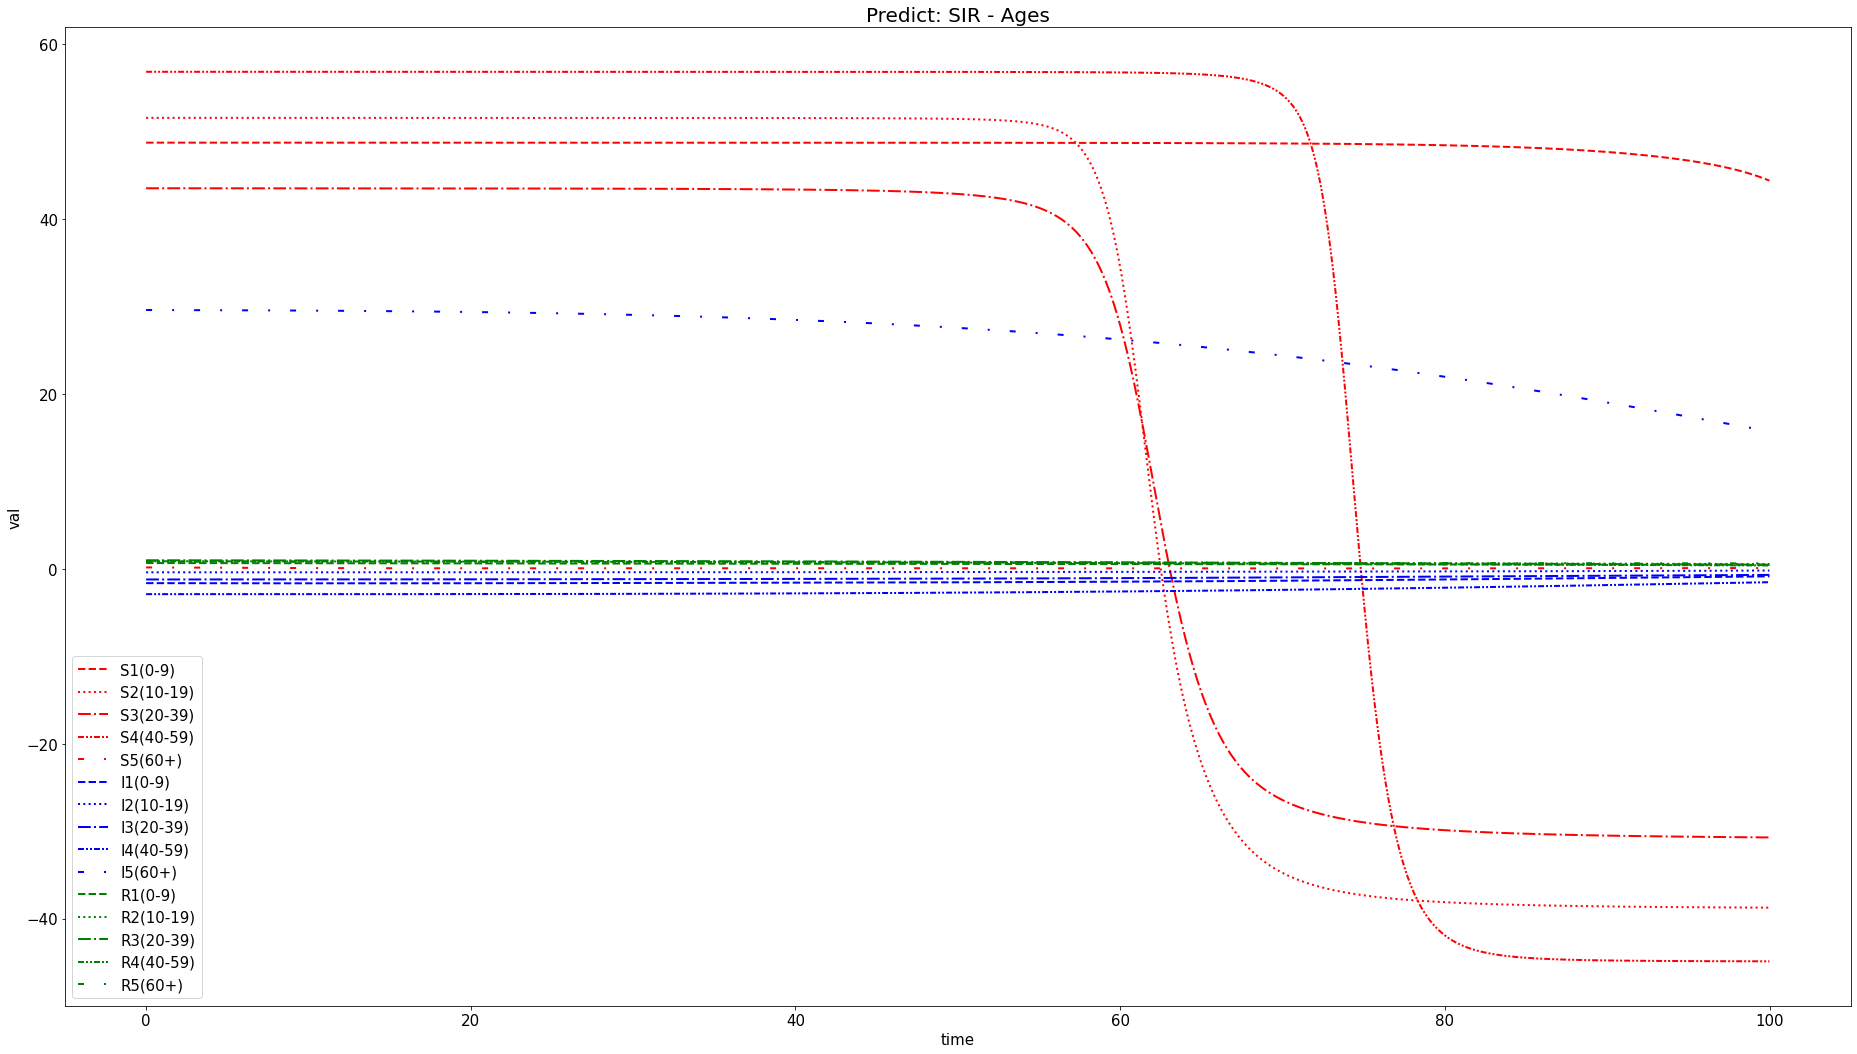

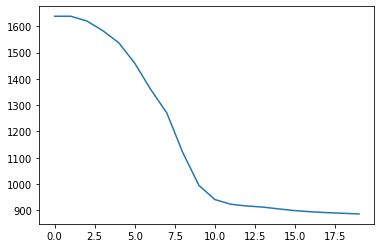

Epoch [00021/00500] Loss:884.317932 Loss_1:878.798462 Loss_2:5.519478 Loss_3:0.000018 Lr:0.000100 Time:12.686758s (2.02min in total)
Epoch [00022/00500] Loss:883.257690 Loss_1:877.871948 Loss_2:5.385714 Loss_3:0.000018 Lr:0.001090 Time:5.832637s (2.12min in total)
Epoch [00023/00500] Loss:883.117859 Loss_1:877.753662 Loss_2:5.364200 Loss_3:0.000018 Lr:0.002080 Time:5.778546s (2.22min in total)
Epoch [00024/00500] Loss:880.950195 Loss_1:876.032532 Loss_2:4.917650 Loss_3:0.000018 Lr:0.003070 Time:5.757690s (2.31min in total)
Epoch [00025/00500] Loss:878.699219 Loss_1:874.240356 Loss_2:4.458848 Loss_3:0.000018 Lr:0.004060 Time:5.720336s (2.41min in total)
Epoch [00026/00500] Loss:876.790466 Loss_1:872.573364 Loss_2:4.217116 Loss_3:0.000018 Lr:0.005050 Time:5.850113s (2.51min in total)
Epoch [00027/00500] Loss:875.203613 Loss_1:871.018433 Loss_2:4.185165 Loss_3:0.000018 Lr:0.006040 Time:5.716621s (2.60min in total)
Epoch [00028/00500] Loss:873.820984 Loss_1:869.589600 Loss_2:4.231392 Loss_

<Figure size 432x288 with 0 Axes>

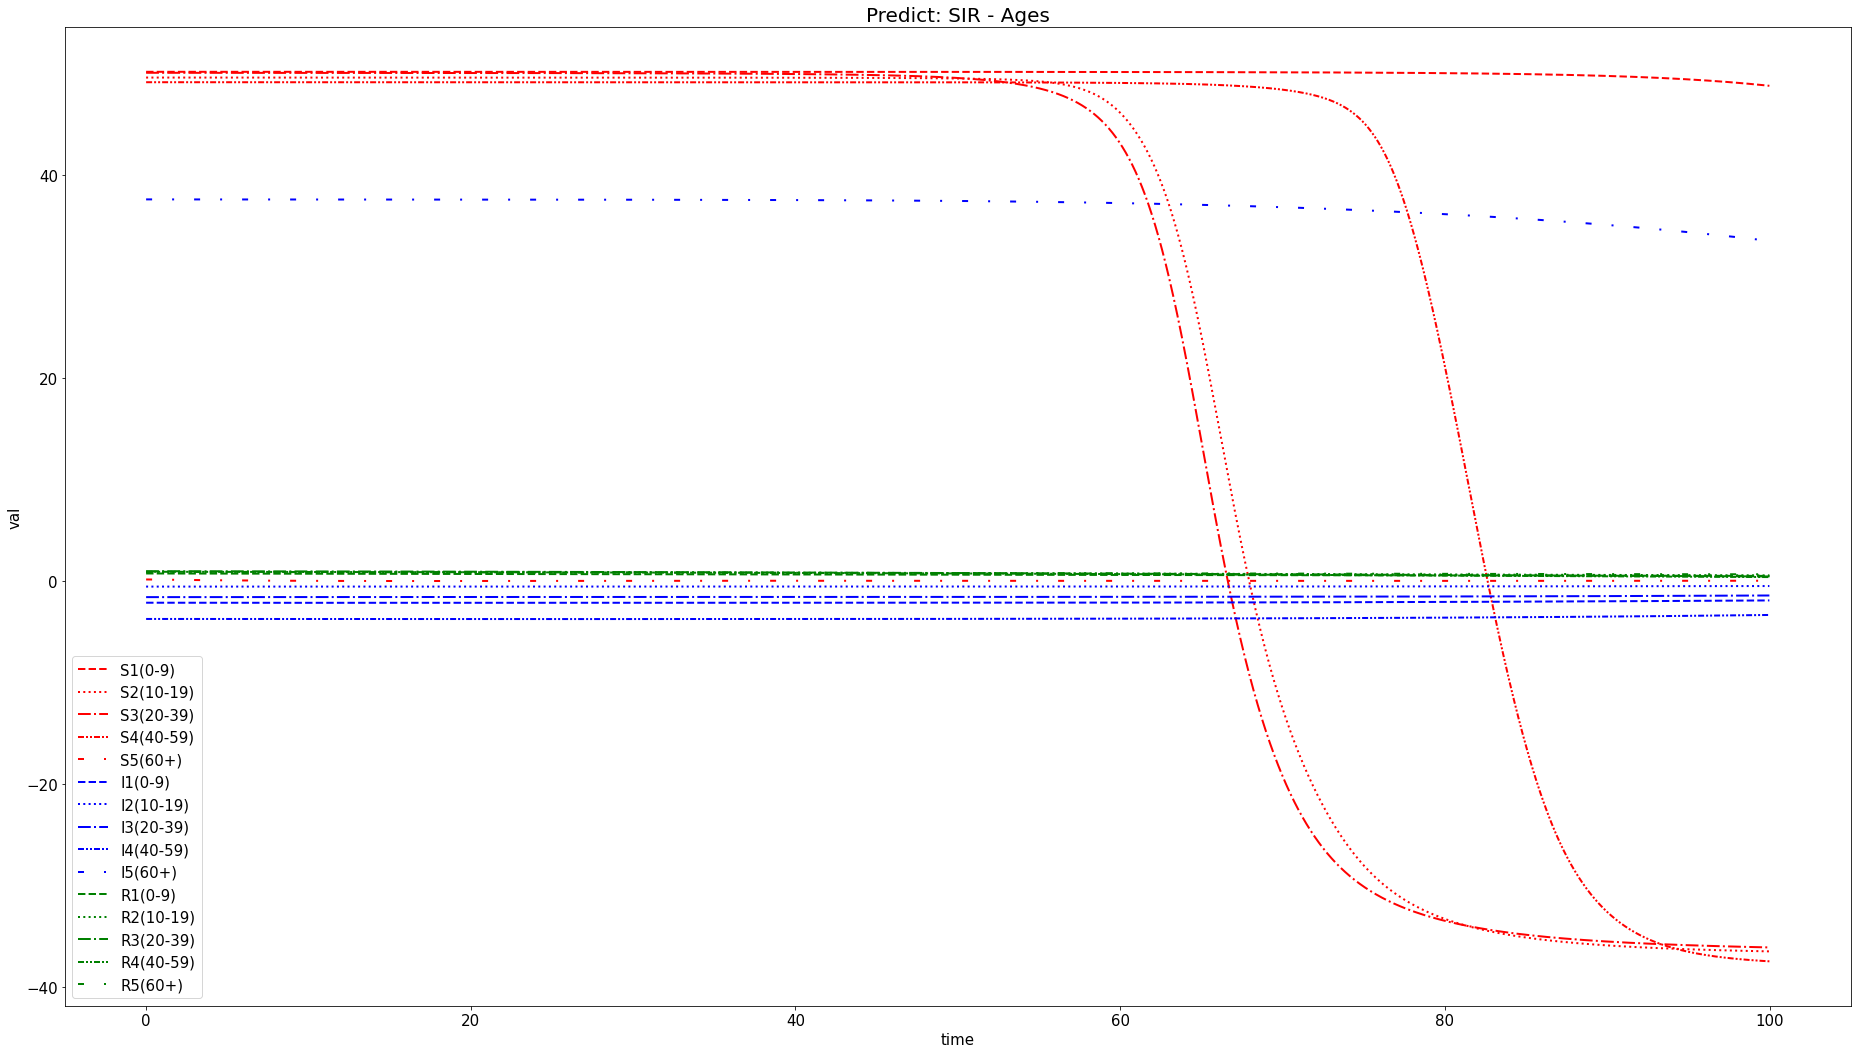

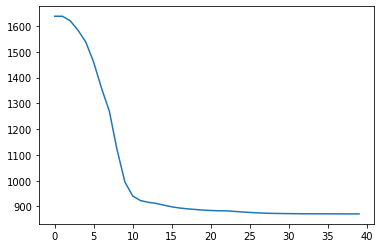

Epoch [00041/00500] Loss:871.022827 Loss_1:867.721252 Loss_2:3.301558 Loss_3:0.000018 Lr:0.000100 Time:12.003596s (4.05min in total)
Epoch [00042/00500] Loss:871.008545 Loss_1:867.723816 Loss_2:3.284751 Loss_3:0.000018 Lr:0.001090 Time:0.452562s (4.06min in total)
Epoch [00043/00500] Loss:871.008362 Loss_1:867.723755 Loss_2:3.284581 Loss_3:0.000018 Lr:0.002080 Time:2.939780s (4.11min in total)
Epoch [00044/00500] Loss:871.000427 Loss_1:867.725464 Loss_2:3.274936 Loss_3:0.000018 Lr:0.003070 Time:5.798695s (4.20min in total)
Epoch [00045/00500] Loss:870.964844 Loss_1:867.735229 Loss_2:3.229628 Loss_3:0.000018 Lr:0.004060 Time:5.847137s (4.30min in total)
Epoch [00046/00500] Loss:870.860535 Loss_1:867.753174 Loss_2:3.107371 Loss_3:0.000018 Lr:0.005050 Time:5.786890s (4.40min in total)
Epoch [00047/00500] Loss:870.730408 Loss_1:867.766602 Loss_2:2.963812 Loss_3:0.000018 Lr:0.006040 Time:5.927147s (4.49min in total)
Epoch [00048/00500] Loss:870.447021 Loss_1:867.725098 Loss_2:2.721920 Loss_

In [ ]:
# SIR Ages - Design D
# LBFGS version
main_path = "/content/drive/My Drive/Workspace/PINN"  # you may need to alter the path if it's not here
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args = Args
if main_path:
    args.main_path = main_path
if not os.path.exists("{}/train".format(args.main_path)):
    os.makedirs("{}/train".format(args.main_path))
if not os.path.exists("{}/figure".format(args.main_path)):
    os.makedirs("{}/figure".format(args.main_path))
now_string = get_now_string()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = ConfigSIRAges
model = SimpleNetworkSIRAges(config).to(device)

model.train()
model_save_path_last = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.beta}_{config.gamma}_{now_string}_last.pt"
model_save_path_best = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.beta}_{config.gamma}_{now_string}_best.pt"
loss_save_path = f"{args.main_path}/loss/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.beta}_{config.gamma}_{now_string}_loss_{args.epoch}.npy"


print("using " + str(device))
print("epoch = {}".format(args.epoch))
print("epoch_step = {}".format(args.epoch_step))
print("model_name = {}".format(model.model_name))
print("now_string = {}".format(now_string))
print("model_save_path_last = {}".format(model_save_path_last))
print("model_save_path_best = {}".format(model_save_path_best))
print("loss_save_path = {}".format(loss_save_path))
# optimizer = optim.Adam(model.parameters(), lr=args.lr)
initial_lr = args.lr
# optimizer = optim.Adam(model.parameters(), lr = initial_lr)

# params = torch.nn.Parameter(1*torch.ones(1).to(device), requires_grad=True)

optimizer = optim.LBFGS(model.parameters(), lr=args.lr, max_iter=100)
# scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1/(epoch/1000+1))
scheduler = CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, step_size=10)


# optimizer = optim.LBFGS(model.parameters(), lr=args.lr, max_iter=5000, max_eval=None, tolerance_grad=1e-05, tolerance_change=1e-09, history_size=100,
#       line_search_fn=None)
epoch_step = args.epoch_step
start_time = time.time()
start_time_0 = start_time

train_x = model.x
loss_record = []


for epoch in range(1, args.epoch + 1):
    # optimizer.zero_grad()
    # inputs = model.x
    # outputs = model(inputs)
    # u_hat, v_hat = torch.chunk(outputs, 2, 1)
    
    # Changes here
    loss, loss_list = model.loss()
    loss_1, loss_2, loss_3 = loss_list[0], loss_list[1], loss_list[2]
    # loss.backward()
    # optimizer.step()

    def closure():
        #optimizer.zero_grad()
        optimizer.zero_grad()
        output = model(train_x)
        l, loss_list = model.loss()
        l.backward()
        return l

    optimizer.step(closure)

    # options = {'closure': closure, 'current_loss': loss, 'max_ls': 10}

    scheduler.step()
    best_loss = 1e20
    loss_record.append(float(loss.item()))
    if epoch % epoch_step == 0:
        now_time = time.time()
        print("Epoch [{0:05d}/{1:05d}] Loss:{2:.6f} Loss_1:{3:.6f} Loss_2:{4:.6f} Loss_3:{5:.6f} Lr:{6:.6f} Time:{7:.6f}s ({8:.2f}min in total)".format(epoch, args.epoch, loss.item(), loss_1.item(), loss_2.item(), loss_3.item(), optimizer.param_groups[0]["lr"], time.time() - start_time, (now_time - start_time_0) / 60.0))
        start_time = now_time
        torch.save(
            {
                'epoch': args.epoch,
                'model_state_dict': model.state_dict(),
                # 'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss.item()
            }, model_save_path_last)
        # print(inputs.shape)
        if loss.item() < best_loss:
            torch.save(
                {
                    'epoch': args.epoch,
                    'model_state_dict': model.state_dict(),
                    # 'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss.item()
                }, model_save_path_best)
            best_loss = loss.item()
    if epoch % args.save_step == 0:
        test_sir_ages(model, args, config, now_string, True)
        draw_loss(np.asarray(loss_record))

num_parameter = -1  # get_model_parameters(model, config)
best_loss = best_loss
time_cost = (now_time - start_time_0) / 60.0
loss_record = np.asarray(loss_record)
np.save(loss_save_path, loss_record)

using cuda
epoch = 200
epoch_step = 10
model_name = SimpleNetworkSIS
now_string = 2022-04-05-04-23-59
model_save_path_last = /content/drive/My Drive/Workspace/PINN/train/SimpleNetworkSIS_200_10_0.001_0.4_0.04_2022-04-05-04-23-59_last.pt
model_save_path_best = /content/drive/My Drive/Workspace/PINN/train/SimpleNetworkSIS_200_10_0.001_0.4_0.04_2022-04-05-04-23-59_best.pt
loss_save_path = /content/drive/My Drive/Workspace/PINN/loss/SimpleNetworkSIS_200_10_0.001_0.4_0.04_2022-04-05-04-23-59_loss_200.npy
Epoch [00010/00200] Loss:4.385890 Loss_1:0.993828 Loss_2:3.392061 Loss_3:0.000000 Lr:0.000990 Time:20.769258s (0.35min in total)
Epoch [00020/00200] Loss:0.537250 Loss_1:0.001285 Loss_2:0.535965 Loss_3:0.000000 Lr:0.000980 Time:21.398914s (0.70min in total)
Epoch [00030/00200] Loss:0.199641 Loss_1:0.000367 Loss_2:0.199275 Loss_3:0.000000 Lr:0.000971 Time:21.223898s (1.06min in total)
Epoch [00040/00200] Loss:0.028498 Loss_1:0.000046 Loss_2:0.028452 Loss_3:0.000000 Lr:0.000962 Time:24.785387

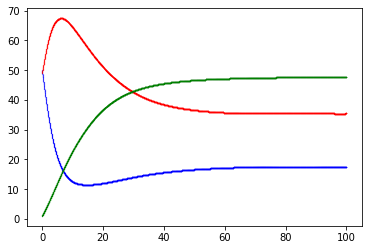

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkSIS_200_10_0.001_0.4_0.04_2022-04-05-04-23-59_1649132828.png


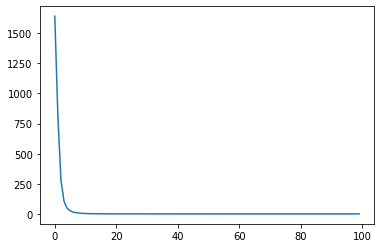

Epoch [00110/00200] Loss:0.000316 Loss_1:0.000001 Loss_2:0.000315 Loss_3:0.000000 Lr:0.000901 Time:8.971978s (3.30min in total)
Epoch [00120/00200] Loss:0.000314 Loss_1:0.000002 Loss_2:0.000313 Loss_3:0.000000 Lr:0.000893 Time:7.095406s (3.41min in total)
Epoch [00130/00200] Loss:0.000313 Loss_1:0.000002 Loss_2:0.000310 Loss_3:0.000000 Lr:0.000885 Time:10.209145s (3.58min in total)
Epoch [00140/00200] Loss:0.000312 Loss_1:0.000002 Loss_2:0.000309 Loss_3:0.000000 Lr:0.000877 Time:9.002768s (3.73min in total)
Epoch [00150/00200] Loss:0.000310 Loss_1:0.000002 Loss_2:0.000308 Loss_3:0.000000 Lr:0.000870 Time:8.333244s (3.87min in total)
Epoch [00160/00200] Loss:0.000310 Loss_1:0.000002 Loss_2:0.000308 Loss_3:0.000000 Lr:0.000862 Time:7.819227s (4.00min in total)
Epoch [00170/00200] Loss:0.000309 Loss_1:0.000002 Loss_2:0.000307 Loss_3:0.000000 Lr:0.000855 Time:6.170593s (4.11min in total)
Epoch [00180/00200] Loss:0.000308 Loss_1:0.000002 Loss_2:0.000306 Loss_3:0.000000 Lr:0.000847 Time:6.36

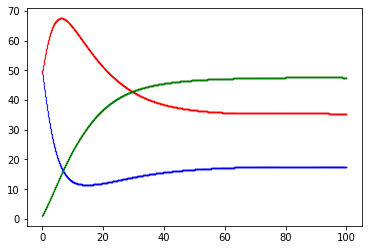

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkSIS_200_10_0.001_0.4_0.04_2022-04-05-04-23-59_1649132905.png


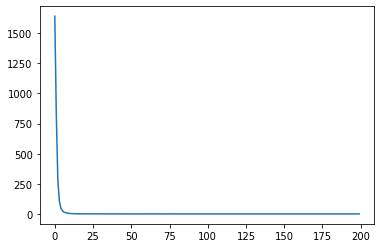

<Figure size 432x288 with 0 Axes>

In [ ]:
# SIR Ages - Design D
# LBFGS version
main_path = "/content/drive/My Drive/Workspace/PINN"  # you may need to alter the path if it's not here
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args = Args
if main_path:
    args.main_path = main_path
if not os.path.exists("{}/train".format(args.main_path)):
    os.makedirs("{}/train".format(args.main_path))
if not os.path.exists("{}/figure".format(args.main_path)):
    os.makedirs("{}/figure".format(args.main_path))
now_string = get_now_string()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = ConfigSIS
model = SimpleNetworkSIS(config).to(device)

model.train()
model_save_path_last = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.beta}_{config.gamma}_{now_string}_last.pt"
model_save_path_best = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.beta}_{config.gamma}_{now_string}_best.pt"
loss_save_path = f"{args.main_path}/loss/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.beta}_{config.gamma}_{now_string}_loss_{args.epoch}.npy"


print("using " + str(device))
print("epoch = {}".format(args.epoch))
print("epoch_step = {}".format(args.epoch_step))
print("model_name = {}".format(model.model_name))
print("now_string = {}".format(now_string))
print("model_save_path_last = {}".format(model_save_path_last))
print("model_save_path_best = {}".format(model_save_path_best))
print("loss_save_path = {}".format(loss_save_path))
# optimizer = optim.Adam(model.parameters(), lr=args.lr)
initial_lr = args.lr
# optimizer = optim.Adam(model.parameters(), lr = initial_lr)

# params = torch.nn.Parameter(1*torch.ones(1).to(device), requires_grad=True)

optimizer = optim.LBFGS(model.parameters(), lr=args.lr, max_iter=100)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1/(epoch/1000+1))
# optimizer = optim.LBFGS(model.parameters(), lr=args.lr, max_iter=5000, max_eval=None, tolerance_grad=1e-05, tolerance_change=1e-09, history_size=100,
#       line_search_fn=None)
epoch_step = args.epoch_step
start_time = time.time()
start_time_0 = start_time

train_x = model.x
loss_record = []


for epoch in range(1, args.epoch + 1):
    # optimizer.zero_grad()
    # inputs = model.x
    # outputs = model(inputs)
    # u_hat, v_hat = torch.chunk(outputs, 2, 1)
    
    # Changes here
    loss, loss_list = model.loss()
    loss_1, loss_2, loss_3 = loss_list[0], loss_list[1], loss_list[2]
    # loss.backward()
    # optimizer.step()

    def closure():
        #optimizer.zero_grad()
        optimizer.zero_grad()
        output = model(train_x)
        l, loss_list = model.loss()
        l.backward()
        return l

    optimizer.step(closure)

    # options = {'closure': closure, 'current_loss': loss, 'max_ls': 10}

    scheduler.step()
    best_loss = 1e20
    loss_record.append(float(loss.item()))
    if epoch % epoch_step == 0:
        now_time = time.time()
        print("Epoch [{0:05d}/{1:05d}] Loss:{2:.6f} Loss_1:{3:.6f} Loss_2:{4:.6f} Loss_3:{5:.6f} Lr:{6:.6f} Time:{7:.6f}s ({8:.2f}min in total)".format(epoch, args.epoch, loss.item(), loss_1.item(), loss_2.item(), loss_3.item(), optimizer.param_groups[0]["lr"], time.time() - start_time, (now_time - start_time_0) / 60.0))
        start_time = now_time
        torch.save(
            {
                'epoch': args.epoch,
                'model_state_dict': model.state_dict(),
                # 'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss.item()
            }, model_save_path_last)
        # print(inputs.shape)
        if loss.item() < best_loss:
            torch.save(
                {
                    'epoch': args.epoch,
                    'model_state_dict': model.state_dict(),
                    # 'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss.item()
                }, model_save_path_best)
            best_loss = loss.item()
    if epoch % args.save_step == 0:
        test_sis(model, args, config, now_string, True)
        draw_loss(np.asarray(loss_record))

num_parameter = -1  # get_model_parameters(model, config)
best_loss = best_loss
time_cost = (now_time - start_time_0) / 60.0
loss_record = np.asarray(loss_record)
np.save(loss_save_path, loss_record)

using cuda
epoch = 200
epoch_step = 10
model_name = SimpleNetworkSIS
now_string = 2022-04-05-04-31-58
model_save_path_last = /content/drive/My Drive/Workspace/PINN/train/SimpleNetworkSIS_200_10_0.001_0.4_0.04_2022-04-05-04-31-58_last.pt
model_save_path_best = /content/drive/My Drive/Workspace/PINN/train/SimpleNetworkSIS_200_10_0.001_0.4_0.04_2022-04-05-04-31-58_best.pt
loss_save_path = /content/drive/My Drive/Workspace/PINN/loss/SimpleNetworkSIS_200_10_0.001_0.4_0.04_2022-04-05-04-31-58_loss_200.npy
Epoch [00010/00200] Loss:5.631307 Loss_1:0.620286 Loss_2:5.011021 Loss_3:0.000000 Lr:0.000990 Time:18.105077s (0.30min in total)
Epoch [00020/00200] Loss:0.732931 Loss_1:0.001460 Loss_2:0.731471 Loss_3:0.000000 Lr:0.000980 Time:19.640622s (0.63min in total)
Epoch [00030/00200] Loss:0.246524 Loss_1:0.000319 Loss_2:0.246205 Loss_3:0.000000 Lr:0.000971 Time:19.177369s (0.95min in total)
Epoch [00040/00200] Loss:0.037348 Loss_1:0.000042 Loss_2:0.037306 Loss_3:0.000000 Lr:0.000962 Time:18.565581

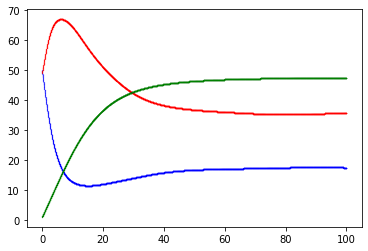

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkSIS_200_10_0.001_0.4_0.04_2022-04-05-04-31-58_1649133302.png


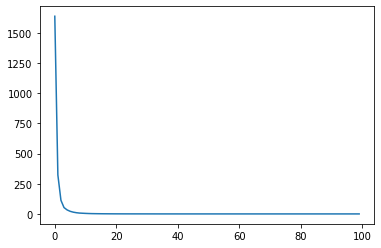

Epoch [00110/00200] Loss:0.001332 Loss_1:0.000002 Loss_2:0.001330 Loss_3:0.000000 Lr:0.000901 Time:12.406436s (3.27min in total)
Epoch [00120/00200] Loss:0.001329 Loss_1:0.000004 Loss_2:0.001325 Loss_3:0.000000 Lr:0.000893 Time:11.614854s (3.47min in total)
Epoch [00130/00200] Loss:0.001329 Loss_1:0.000006 Loss_2:0.001324 Loss_3:0.000000 Lr:0.000885 Time:9.250310s (3.62min in total)
Epoch [00140/00200] Loss:0.001328 Loss_1:0.000006 Loss_2:0.001323 Loss_3:0.000000 Lr:0.000877 Time:9.061673s (3.77min in total)
Epoch [00150/00200] Loss:0.001328 Loss_1:0.000005 Loss_2:0.001323 Loss_3:0.000000 Lr:0.000870 Time:8.065998s (3.91min in total)
Epoch [00160/00200] Loss:0.001328 Loss_1:0.000005 Loss_2:0.001323 Loss_3:0.000000 Lr:0.000862 Time:10.895294s (4.09min in total)
Epoch [00170/00200] Loss:0.001327 Loss_1:0.000004 Loss_2:0.001323 Loss_3:0.000000 Lr:0.000855 Time:11.236281s (4.28min in total)
Epoch [00180/00200] Loss:0.001325 Loss_1:0.000003 Loss_2:0.001322 Loss_3:0.000000 Lr:0.000847 Time:8

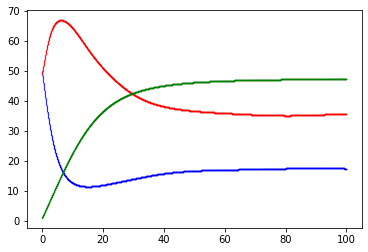

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkSIS_200_10_0.001_0.4_0.04_2022-04-05-04-31-58_1649133401.png


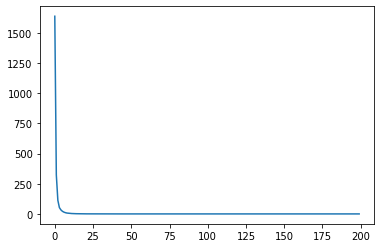

<Figure size 432x288 with 0 Axes>

In [ ]:
# SIR Ages - Design A
# LBFGS version
main_path = "/content/drive/My Drive/Workspace/PINN"  # you may need to alter the path if it's not here
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args = Args
if main_path:
    args.main_path = main_path
if not os.path.exists("{}/train".format(args.main_path)):
    os.makedirs("{}/train".format(args.main_path))
if not os.path.exists("{}/figure".format(args.main_path)):
    os.makedirs("{}/figure".format(args.main_path))
now_string = get_now_string()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = ConfigSIRAges
model = SimpleNetworkSIRAges(config).to(device)

model.train()
model_save_path_last = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.beta}_{config.gamma}_{now_string}_last.pt"
model_save_path_best = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.beta}_{config.gamma}_{now_string}_best.pt"
loss_save_path = f"{args.main_path}/loss/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.beta}_{config.gamma}_{now_string}_loss_{args.epoch}.npy"


print("using " + str(device))
print("epoch = {}".format(args.epoch))
print("epoch_step = {}".format(args.epoch_step))
print("model_name = {}".format(model.model_name))
print("now_string = {}".format(now_string))
print("model_save_path_last = {}".format(model_save_path_last))
print("model_save_path_best = {}".format(model_save_path_best))
print("loss_save_path = {}".format(loss_save_path))
# optimizer = optim.Adam(model.parameters(), lr=args.lr)
initial_lr = args.lr
# optimizer = optim.Adam(model.parameters(), lr = initial_lr)

# params = torch.nn.Parameter(1*torch.ones(1).to(device), requires_grad=True)

optimizer = optim.LBFGS(model.parameters(), lr=args.lr, max_iter=100)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1/(epoch/1000+1))
# optimizer = optim.LBFGS(model.parameters(), lr=args.lr, max_iter=5000, max_eval=None, tolerance_grad=1e-05, tolerance_change=1e-09, history_size=100,
#       line_search_fn=None)
epoch_step = args.epoch_step
start_time = time.time()
start_time_0 = start_time

train_x = model.x
loss_record = []


for epoch in range(1, args.epoch + 1):
    # optimizer.zero_grad()
    # inputs = model.x
    # outputs = model(inputs)
    # u_hat, v_hat = torch.chunk(outputs, 2, 1)
    
    # Changes here
    loss, loss_list = model.loss()
    loss_1, loss_2, loss_3 = loss_list[0], loss_list[1], loss_list[2]
    # loss.backward()
    # optimizer.step()

    def closure():
        #optimizer.zero_grad()
        optimizer.zero_grad()
        output = model(train_x)
        l, loss_list = model.loss()
        l.backward()
        return l

    

    optimizer.step(closure)

    # options = {'closure': closure, 'current_loss': loss, 'max_ls': 10}

    scheduler.step()
    best_loss = 1e20
    loss_record.append(float(loss.item()))
    if epoch % epoch_step == 0:
        now_time = time.time()
        print("Epoch [{0:05d}/{1:05d}] Loss:{2:.6f} Loss_1:{3:.6f} Loss_2:{4:.6f} Loss_3:{5:.6f} Lr:{6:.6f} Time:{7:.6f}s ({8:.2f}min in total)".format(epoch, args.epoch, loss.item(), loss_1.item(), loss_2.item(), loss_3.item(), optimizer.param_groups[0]["lr"], time.time() - start_time, (now_time - start_time_0) / 60.0))
        start_time = now_time
        torch.save(
            {
                'epoch': args.epoch,
                'model_state_dict': model.state_dict(),
                # 'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss.item()
            }, model_save_path_last)
        # print(inputs.shape)
        if loss.item() < best_loss:
            torch.save(
                {
                    'epoch': args.epoch,
                    'model_state_dict': model.state_dict(),
                    # 'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss.item()
                }, model_save_path_best)
            best_loss = loss.item()
    if epoch % args.save_step == 0:
        test_sir_ages(model, args, config, now_string, True)
        draw_loss(np.asarray(loss_record))

num_parameter = -1  # get_model_parameters(model, config)
best_loss = best_loss
time_cost = (now_time - start_time_0) / 60.0
loss_record = np.asarray(loss_record)
np.save(loss_save_path, loss_record)

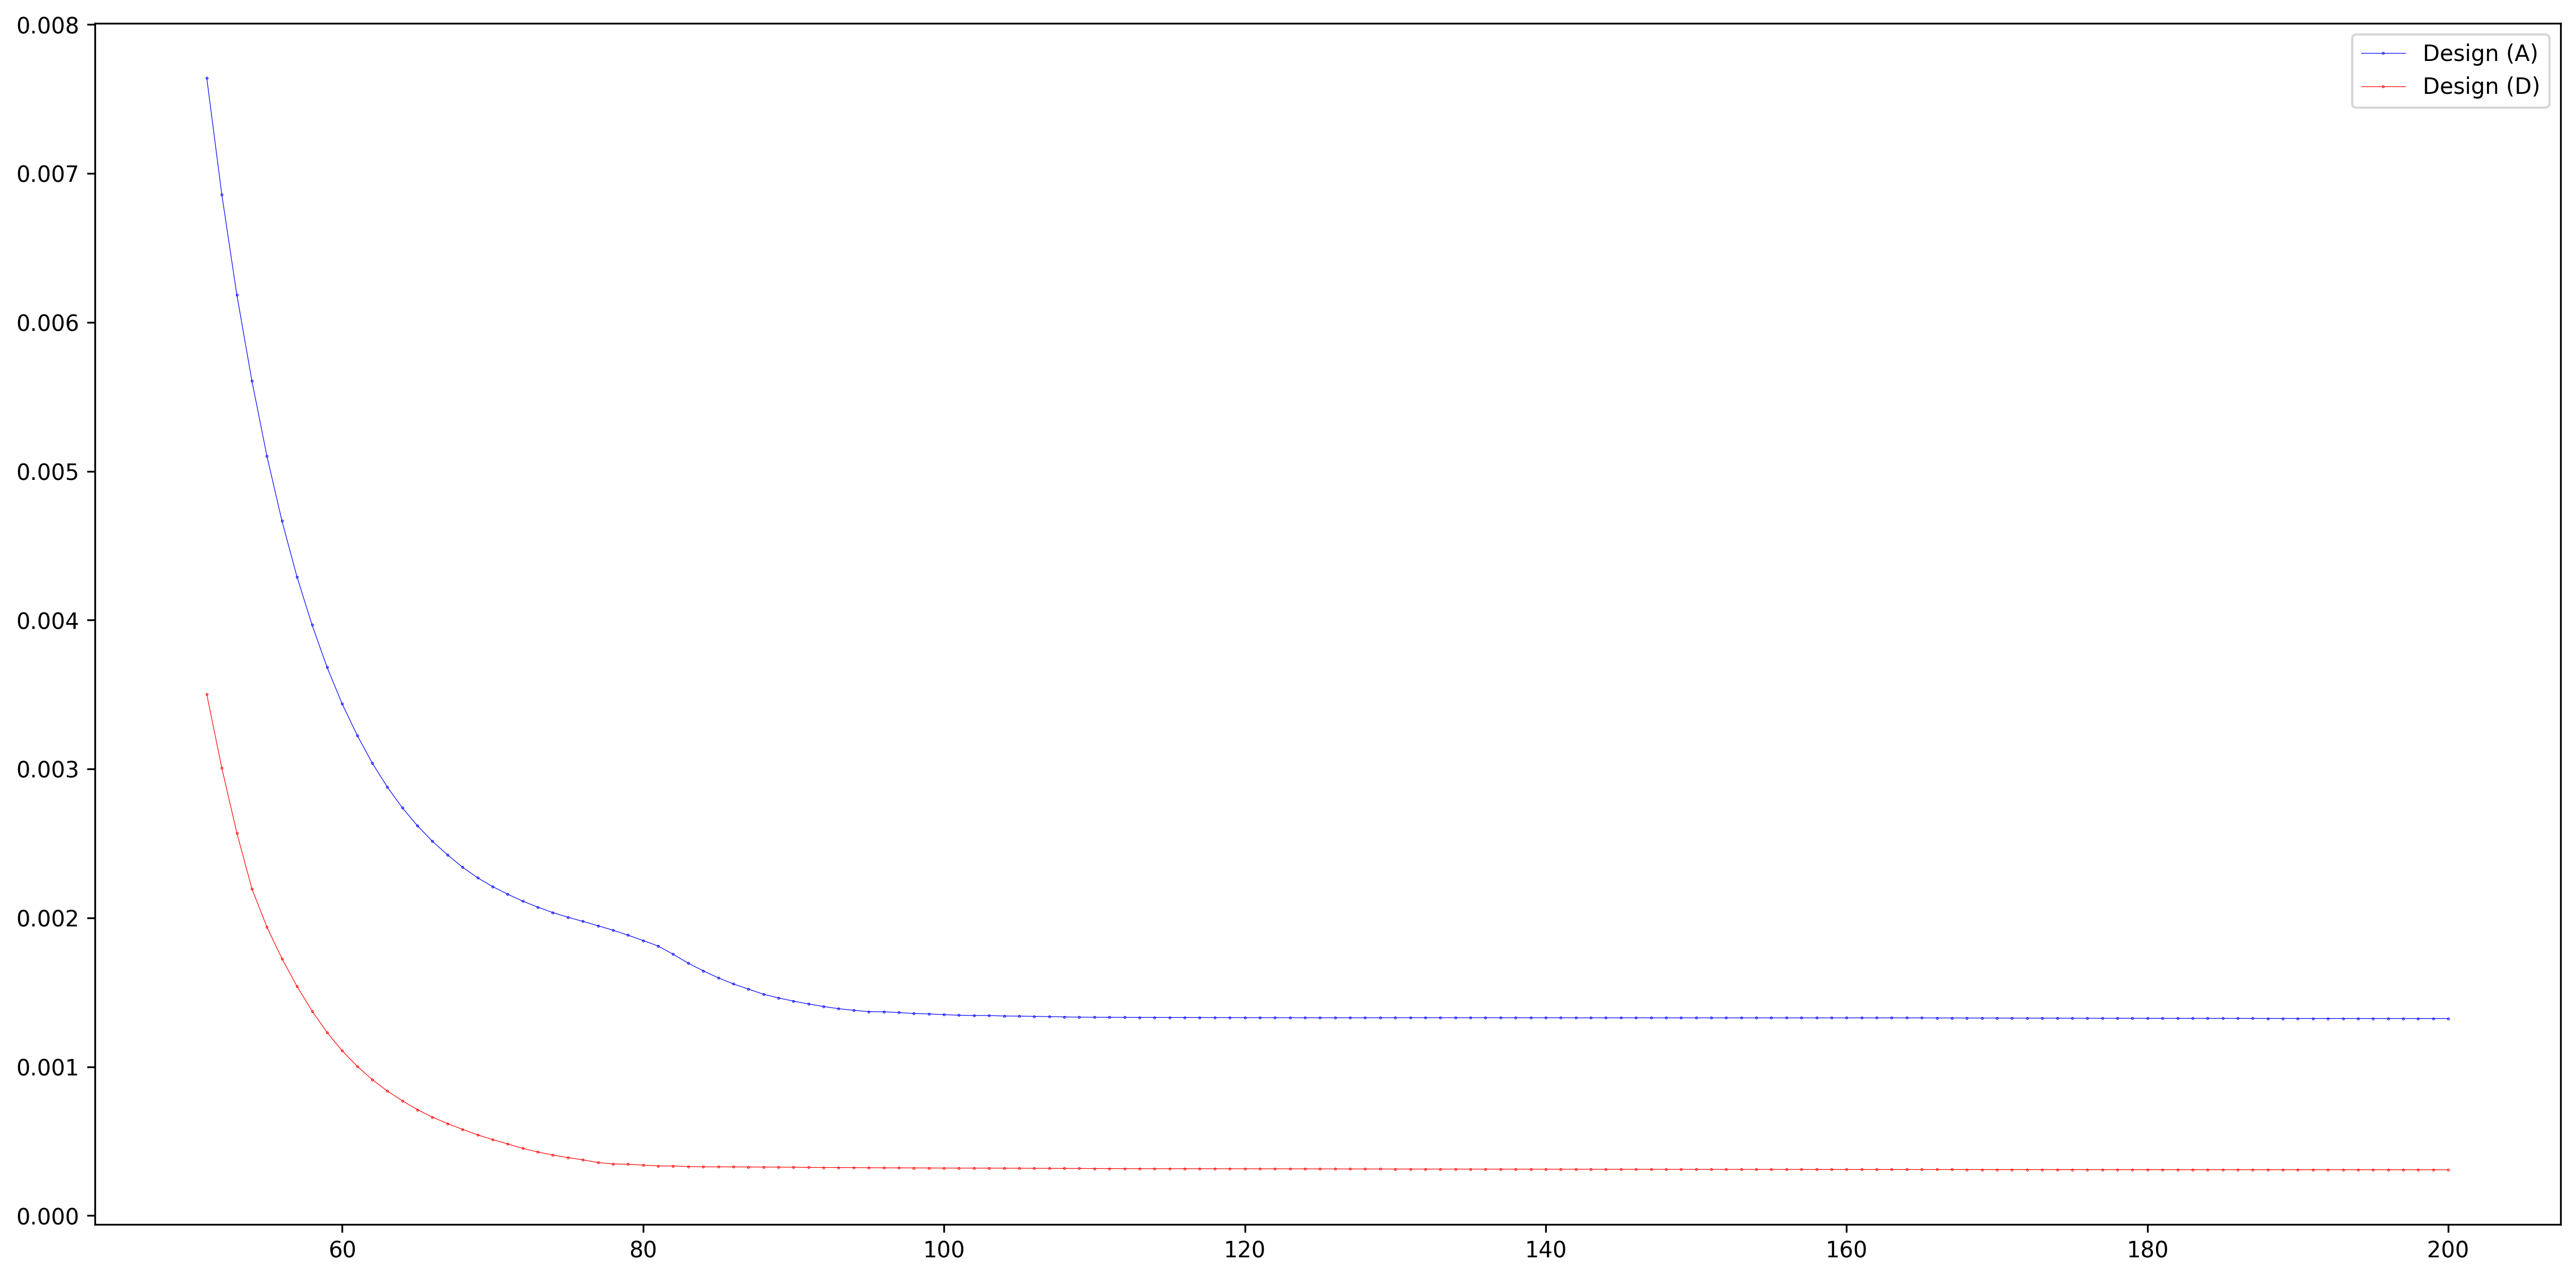

<Figure size 432x288 with 0 Axes>

In [ ]:
# loss
import numpy as np
loss_a = np.load("/content/drive/My Drive/Workspace/PINN/loss/SimpleNetworkSIS_200_10_0.001_0.4_0.04_2022-04-05-04-31-58_loss_200.npy")
loss_d = np.load("/content/drive/My Drive/Workspace/PINN/loss/SimpleNetworkSIS_200_10_0.001_0.4_0.04_2022-04-05-04-23-59_loss_200.npy")

start = 50
end = len(loss_a)
x = range(start + 1, end + 1)
plt.figure(dpi=300, figsize=[20,10])
plt.plot(x, loss_a[start:], marker='.', markersize=0.5, linewidth=0.3, c="b")
plt.plot(x, loss_d[start:], marker='.', markersize=0.5, linewidth=0.3, c="r")
plt.legend(["Design (A)","Design (D)"])
plt.show()
plt.clf()